<a href="https://colab.research.google.com/github/LAOLIVEIRA1972/PUC_MVP/blob/main/mvp_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução


---

### 1.1- Objetivo
O objetivo desse projeto é criar e avaliar um modelo de Machine Learning que possa estimar a duração de paradas programadas de plataformas petrolíferas de acordo com as suas características.

### 1.2- Descrição do problema
A parada programada de uma plataforma petrolífera deve ser planejada de forma a otimizar a duração do evento, a fim de minimizar o impacto na produção de petróleo.
A duração das paradas programadas depende da complexidade e extensão da manutenção necessária, podendo variar de alguns dias a algumas semanas, ou até meses.
Alguns desses fatores serão analisados neste projeto, como: idade, tipo e propriedade da plataforma; lâmina d'água e bacia; tipo de operação (produção ou injeção).

### 1.3- Premissas
Foram consideradas apenas paradas programadas, ou seja, aquelas previstas dentro do Plano de Negócio da Empresa. Paradas não programadas não foram consideradas, como por exemplo, paradas por interdição de Órgãos fiscalizadores.
Foram coletadas informações de paradas programadas a partir de 2012 apenas em bacias sedimentares do Sudeste.

### 1.4- Descrição do Dataset
O dataset é composto por um pouco mais de 600 registros, com as seguintes informações:
- Plataforma: identificação da plataforma.
- Tipo: tipo da plataforma (FPSO, Fixa, Semi-submersível).
- Propriedade: indica se a plataforma é própria ou afretada.
- LDA: lâmina d'água (Rasa, Produnda ou Ultraprofunda) onde a plataforma opera.
- Bacia: bacia sedimentar onde a plataforma opera.
- Restrição de queima: indica se a parada ocasionará restrição na queima.
- Tipo operação: indica se o impacto será na produção ou injeção.
- Idade: idade em anos da plataforma na parda.
- Duração: duração da parada em dias.

# 2. Importação de bibliotecas necessárias


---



In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
from sklearn.preprocessing import StandardScaler # algoritmo para padronização dos dados
from sklearn.preprocessing import MinMaxScaler # algoritmo para normalização dos dados
from sklearn.pipeline import Pipeline # pipeline
from sklearn.ensemble import BaggingRegressor # método de ensemble Bagging
from sklearn.ensemble import RandomForestRegressor # método de ensemble RadomForest
from sklearn.ensemble import ExtraTreesRegressor # método de ensemble ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor # método de ensemble VotingRegressor
from sklearn.ensemble import AdaBoostRegressor # método de ensemble AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor # método de ensemble GradientBoostingRegressor



# 3. Preparação dos dados


---



### 3.1- Leitura do Dataset

In [ ]:
# Informa a URL de importação do dataset (usando o link raw para o arquivo no GitHub)
url = "https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP/main/dataset_plataformas.xlsx"

# Lê o arquivo
dataset = pd.read_excel(url)

# Mostra as primeiras linhas do dataset
display(dataset.head())

# transforma atributos categóricos em numéricos
cols_cat = ["PLATAFORMA", "TIPO", "PROPRIEDADE","LDA", "BACIA", "RESTRICAO_QUEIMA", "TIPO_OPERACAO"]
for col in cols_cat:
    dataset[col] = dataset[col].replace({sorted(dataset[col].unique())[i]:i for i in range(len(sorted(dataset[col].unique())))})

# Mostra as primeiras linhas do dataset
display(dataset.head())

,PLATAFORMA,TIPO,PROPRIEDADE,LDA,BACIA,RESTRICAO_QUEIMA,TIPO_OPERACAO,IDADE,DURAÇÃO
0,PA04,FPSO,Afretado,P,B1,NÃO,Produção,3,9.0
1,PA05,FPSO,Afretado,P,B1,NÃO,Produção,3,14.0
2,PA05,FPSO,Afretado,P,B1,NÃO,Injeção,3,13.0
3,PA09,FPSO,Afretado,P,B1,NÃO,Produção,4,14.0
4,PA09,FPSO,Afretado,P,B1,NÃO,Produção,6,25.0


,PLATAFORMA,TIPO,PROPRIEDADE,LDA,BACIA,RESTRICAO_QUEIMA,TIPO_OPERACAO,IDADE,DURAÇÃO
0,3,1,0,0,0,0,1,3,9.0
1,4,1,0,0,0,0,1,3,14.0
2,4,1,0,0,0,0,0,3,13.0
3,8,1,0,0,0,0,1,4,14.0
4,8,1,0,0,0,0,1,6,25.0


### 3.2- Separação do dataset em conjuntos de treino e de teste


---

Descrever o uso do holdout e validação cruzada

In [ ]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = dataset.values
X = array[:,0:8] # atributos
y = array[:,8] # classe (target)

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão em bases de treino e teste

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
scoring='neg_mean_squared_error' # usa erro quadrático médio para avaliação do desempenho da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

# 4. Modelagem e inferência


---



### 4.1- Configuração da Seed Global

Configuração de uma seed única para todas as bibliotecas utilizadas no projeto de forma a garantir a reprodutibilidade, ou seja, independente do ambiente de reprodução, os resultados gerados sejam sempre os mesmos.

In [ ]:
# Definindo uma seed global
np.random.seed(7)

### 4.2- Criação e avaliação de modelos com dados da linha base

LR: MSE 749.32 (820.44) - RMSE 27.37
Ridge: MSE 747.52 (819.00) - RMSE 27.34
Lasso: MSE 729.25 (812.70) - RMSE 27.00
KNN: MSE 750.77 (801.48) - RMSE 27.40
CART: MSE 960.21 (714.52) - RMSE 30.99
SVM: MSE 781.37 (831.26) - RMSE 27.95
Bagging: MSE 718.11 (788.98) - RMSE 26.80
RF: MSE 727.90 (783.08) - RMSE 26.98
ET: MSE 916.23 (848.20) - RMSE 30.27
Ada: MSE 1037.66 (837.80) - RMSE 32.21
GB: MSE 748.09 (780.23) - RMSE 27.35
Voting: MSE 704.80 (818.70) - RMSE 26.55


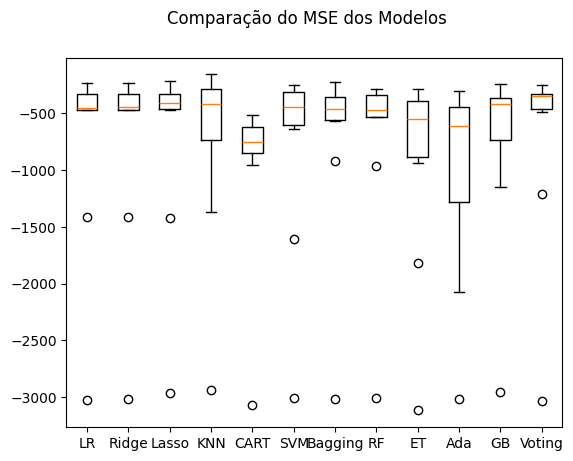

In [ ]:
# Listas para armazenar os modelos, os resultados e os nomes dos modelos
modelos = []
resultados = []
nomes = []

# Preparando os modelos de regressão e adicionando-os em uma lista
modelos.append(('LR', LinearRegression()))
modelos.append(('Ridge', Ridge()))
modelos.append(('Lasso', Lasso()))
modelos.append(('KNN', KNeighborsRegressor()))
modelos.append(('CART', DecisionTreeRegressor()))
modelos.append(('SVM', SVR()))

# Definindo os parâmetros do classificador base para o BaggingRegressor
base = DecisionTreeRegressor()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingRegressor
bases = []
bases.append(('logistic', LinearRegression()))
bases.append(('cart', DecisionTreeRegressor()))
bases.append(('svm', SVR()))

# Criando os ensembles e adicionando-os na lista de modelos
modelos.append(('Bagging', BaggingRegressor(estimator=base, n_estimators=num_trees)))
modelos.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
modelos.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
modelos.append(('Ada', AdaBoostRegressor(n_estimators=num_trees)))
modelos.append(('GB', GradientBoostingRegressor(n_estimators=num_trees)))
modelos.append(('Voting', VotingRegressor(bases)))

# Avaliando um modelo por vez
for nome, modelo in modelos:
  cv_resultados = cross_val_score(modelo, X_treino, y_treino, cv=kfold, scoring=scoring)
  resultados.append(cv_resultados)
  nomes.append(nome)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (nome, abs(cv_resultados.mean()), cv_resultados.std(), np.sqrt(abs(cv_resultados.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

### 4.3- Criação e avalidação de modelos com dados normalizados e padronizados

LR-orig: MSE 749.32 (820.44) - RMSE 27.37
KNN-orig: MSE 750.77 (801.48) - RMSE 27.40
Ridge-orig: MSE 747.52 (819.00) - RMSE 27.34
Lasso-orig: MSE 729.25 (812.70) - RMSE 27.00
CART-orig: MSE 960.21 (714.52) - RMSE 30.99
SVM-orig: MSE 781.37 (831.26) - RMSE 27.95
Bag-orig: MSE 718.11 (788.98) - RMSE 26.80
RF-orig: MSE 727.90 (783.08) - RMSE 26.98
ET-orig: MSE 916.23 (848.20) - RMSE 30.27
Ada-orig: MSE 1037.66 (837.80) - RMSE 32.21
GB-orig: MSE 748.09 (780.23) - RMSE 27.35
Vot-orig: MSE 704.80 (818.70) - RMSE 26.55
LR-padr: MSE 749.32 (820.44) - RMSE 27.37
KNN-padr: MSE 834.89 (850.86) - RMSE 28.89
Ridge-padr: MSE 748.46 (819.78) - RMSE 27.36
Lasso-padr: MSE 729.62 (810.18) - RMSE 27.01
CART-padr: MSE 962.89 (717.82) - RMSE 31.03
SVM-padr: MSE 782.13 (834.16) - RMSE 27.97
Bag-padr: MSE 711.79 (765.48) - RMSE 26.68
RF-padr: MSE 736.31 (780.14) - RMSE 27.14
ET-padr: MSE 966.77 (903.12) - RMSE 31.09
Ada-padr: MSE 959.03 (797.77) - RMSE 30.97
GB-padr: MSE 748.02 (779.87) - RMSE 27.35
Vot-padr

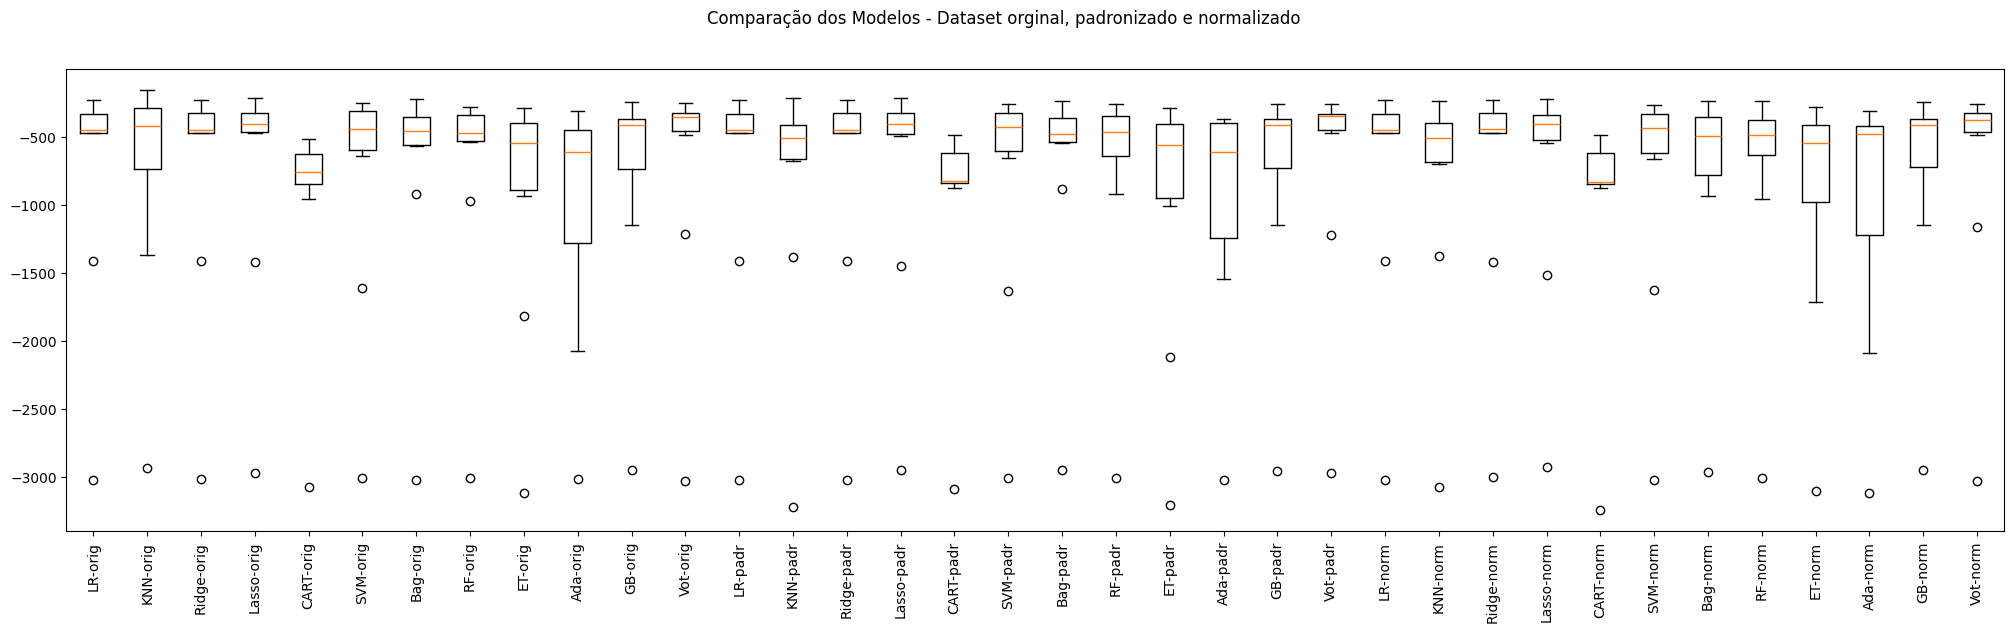

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
resultados = []
nomes = []

# Criando os elementos do pipeline

modelos.append(('LR', LinearRegression()))
modelos.append(('Ridge', Ridge()))
modelos.append(('Lasso', Lasso()))
modelos.append(('KNN', KNeighborsRegressor()))
modelos.append(('CART', DecisionTreeRegressor()))
modelos.append(('SVM', SVR()))

# Algoritmos que serão utilizados
reg_lin = ('LR', LinearRegression())
knn = ('KNN', KNeighborsRegressor())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
cart = ('CART', DecisionTreeRegressor())
svm = ('SVM', SVR())

bagging = ('Bag', BaggingRegressor(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_lin])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_lin])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler,lasso])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_lin])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler,lasso])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for nome, modelo in pipelines:
    cv_resultados = cross_val_score(modelo, X_treino, y_treino, cv=kfold, scoring=scoring)
    resultados.append(cv_resultados)
    nomes.append(nome)
    # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (nome, abs(cv_resultados.mean()), cv_resultados.std(), np.sqrt(abs(cv_resultados.mean())))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes, rotation=90)
plt.show()

In [ ]:
# Criando um modelo com todo o conjunto de treino
modelo = Lasso()
modelo.fit(X_treino, y_treino)

# Fazendo as predições com o conjunto de teste
predicoes = modelo.predict(X_teste)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_teste, predicoes)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

modelo.fit(X, y)

# Teste com novos dados
data = {'PLATAFORMA':  [4, 4, 2],
        'TIPO': [1, 1, 0],
        'PROPRIEDADE': [0, 1, 51],
        'LDA': [0, 0, 0],
        'BACIA': [1, 0, 1],
        'RESTRICAO_QUEIMA': [1, 0, 1],
        'TIPO_OPERACAO': [1, 0, 1],
        'IDADE': [1, 10, 30],
        }

atributos = ['PLATAFORMA', 'TIPO', 'PROPRIEDADE', 'LDA', 'BACIA', 'RESTRICAO_QUEIMA', 'TIPO_OPERACAO', 'IDADE']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8]

saidas = modelo.predict(X_entrada)
print(saidas)

MSE 492.72
RMSE 22.20
[17.46575777 22.60907808 34.00538537]
